Credit goes to https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb for the steps to use graph_tool in Colab.

In [1]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install gravis

Executing: /tmp/apt-key-gpghome.HqcKlaAC34/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://downloads.skewed.de/apt jammy InRelease [7,535 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu j

In [3]:
from google.colab import files
import pickle
from graph_tool.all import *

g = load_graph("HepPh_with_louvain_and_label.graphml")

temporal_community_sets = {}

with open("temporal_community_assignments_Label.dump", "rb") as fp:
    temporal_community_sets["Label Propagation"] = pickle.load(fp)
with open("temporal_community_assignments_Louvain.dump", "rb") as fp:
    temporal_community_sets["Louvain"] = pickle.load(fp)
with open("temporal_community_assignments_SBM.dump", "rb") as fp:
    temporal_community_sets["SBM"] = pickle.load(fp)

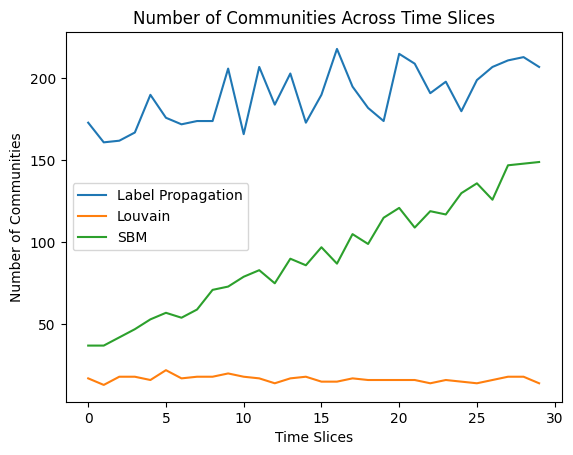

In [ ]:
# Plot the number of unique commnuities per time slice.
# (To track the death and birth of communities)

from matplotlib import pyplot

per_algo_num_unique_comms = {}
for comm_algo in temporal_community_sets.keys():
    per_algo_num_unique_comms[comm_algo] = [[],[]]
    for slice_idx,comm_sets in enumerate(temporal_community_sets[comm_algo]):
        comm_sets = [i for i in comm_sets if i[0]!=-1]
        per_algo_num_unique_comms[comm_algo][0].append(slice_idx)
        per_algo_num_unique_comms[comm_algo][1].append(len(comm_sets))

for comm_algo in per_algo_num_unique_comms.keys():
    pyplot.plot(per_algo_num_unique_comms[comm_algo][0], per_algo_num_unique_comms[comm_algo][1], label=comm_algo)
pyplot.title("Number of Communities Across Time Slices")
pyplot.xlabel("Time Slices")
pyplot.ylabel("Number of Communities")
pyplot.legend()
pyplot.savefig("num_comms_vs_time.png")
pyplot.show()

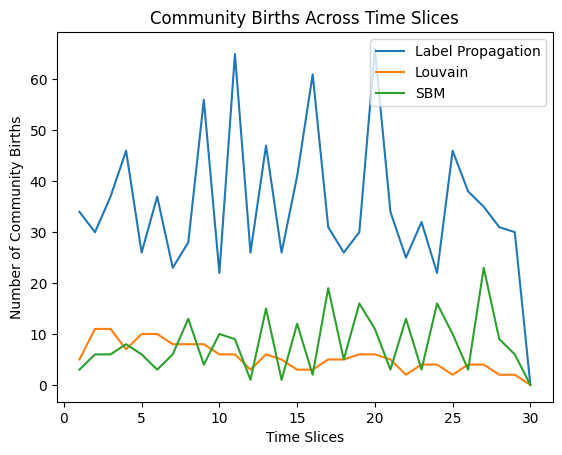

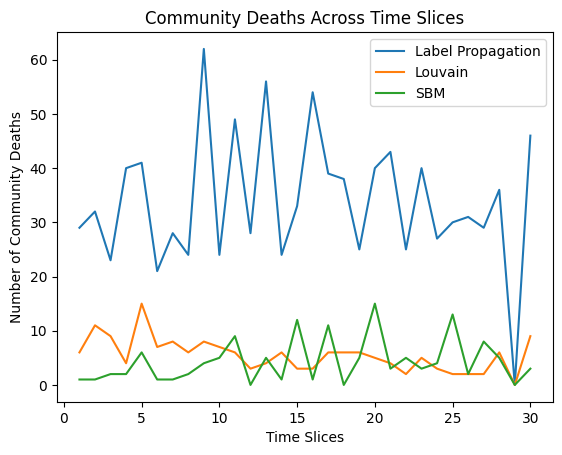

In [ ]:
per_algo_comm_size = {}
for comm_algo in temporal_community_sets.keys():
    temporal_comm_size_data = {}
    for time_slice_idx,per_slice_comm_set in enumerate(temporal_community_sets[comm_algo]):
        for comm in per_slice_comm_set:
            if comm[0] == -1:
                continue
            if comm[0] in temporal_comm_size_data:
                temporal_comm_size_data[comm[0]][0].append(time_slice_idx)
                temporal_comm_size_data[comm[0]][1].append(len(comm[1]))
            else:
                temporal_comm_size_data[comm[0]] = [[time_slice_idx],[len(comm[1])]]
    per_algo_comm_size[comm_algo] = temporal_comm_size_data

per_algo_num_births = {}
per_algo_num_deaths = {}
for comm_algo in per_algo_comm_size.keys():
    birth_count = [0 for i in range(len(temporal_community_sets[comm_algo]))]
    death_count = [0 for i in range(len(birth_count))]
    time_slice_idx = [i+1 for i in range(len(birth_count))]
    for comm_size_data in per_algo_comm_size[comm_algo].values():
        if comm_size_data[0][0] != 0:
            birth_count[comm_size_data[0][0]-1] += 1
        if comm_size_data[0][-1] != len(temporal_community_sets[comm_algo])-1:
            death_count[comm_size_data[0][-1]-1] += 1
    per_algo_num_births[comm_algo] = [time_slice_idx, birth_count]
    per_algo_num_deaths[comm_algo] = [time_slice_idx, death_count]

for comm_algo in per_algo_num_births.keys():
    pyplot.plot(per_algo_num_births[comm_algo][0], per_algo_num_births[comm_algo][1], label=comm_algo)
pyplot.title("Community Births Across Time Slices")
pyplot.xlabel("Time Slices")
pyplot.ylabel("Number of Community Births")
pyplot.legend()
pyplot.savefig("comm_births_vs_time.png")
pyplot.show()
for comm_algo in per_algo_num_deaths.keys():
    pyplot.plot(per_algo_num_deaths[comm_algo][0], per_algo_num_deaths[comm_algo][1], label=comm_algo)
pyplot.title("Community Deaths Across Time Slices")
pyplot.xlabel("Time Slices")
pyplot.ylabel("Number of Community Deaths")
pyplot.legend()
pyplot.savefig("comm_deaths_vs_time.png")
pyplot.show()

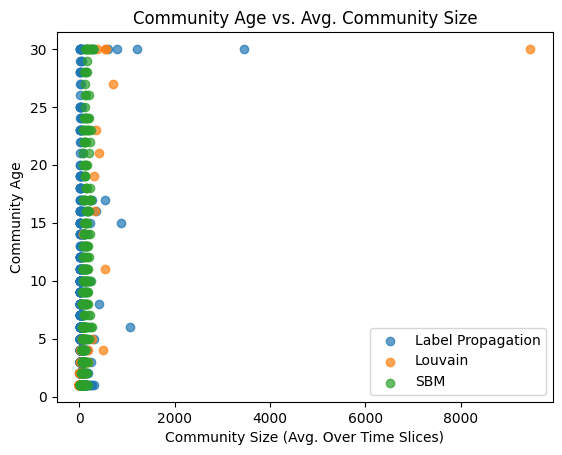

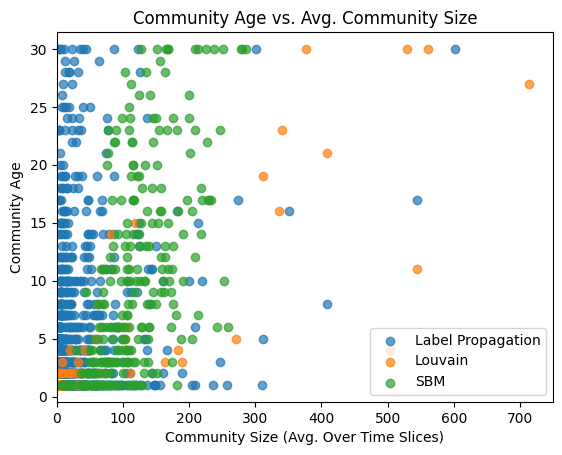

In [ ]:
import numpy as np

per_algo_age_vs_avgsize = {}
for comm_algo in per_algo_comm_size.keys():
    per_algo_age_vs_avgsize[comm_algo] = [[],[]]
    for comm_label in per_algo_comm_size[comm_algo].keys():
        per_algo_age_vs_avgsize[comm_algo][0].append(len(per_algo_comm_size[comm_algo][comm_label][0]))
        per_algo_age_vs_avgsize[comm_algo][1].append(np.mean(per_algo_comm_size[comm_algo][comm_label][1]))

for comm_algo in per_algo_age_vs_avgsize.keys():
    pyplot.scatter(per_algo_age_vs_avgsize[comm_algo][1], per_algo_age_vs_avgsize[comm_algo][0], label=comm_algo, alpha=0.7)
pyplot.title("Community Age vs. Avg. Community Size")
pyplot.ylabel("Community Age")
pyplot.xlabel("Community Size (Avg. Over Time Slices)")
pyplot.legend()
pyplot.savefig("comm_age_vs_size_full.png")
pyplot.show()

for comm_algo in per_algo_age_vs_avgsize.keys():
    pyplot.scatter(per_algo_age_vs_avgsize[comm_algo][1], per_algo_age_vs_avgsize[comm_algo][0], label=comm_algo, alpha=0.7)
pyplot.title("Community Age vs. Avg. Community Size")
pyplot.ylabel("Community Age")
pyplot.xlabel("Community Size (Avg. Over Time Slices)")
pyplot.legend()
ax = pyplot.gca()
ax.set_xlim([0, 750])
pyplot.legend()
pyplot.savefig("comm_age_vs_size_zoom.png")

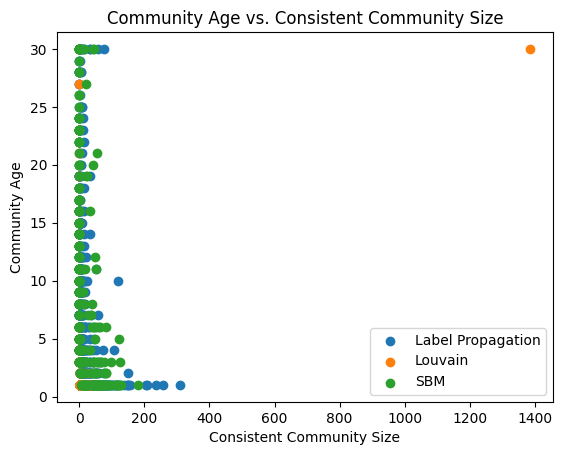

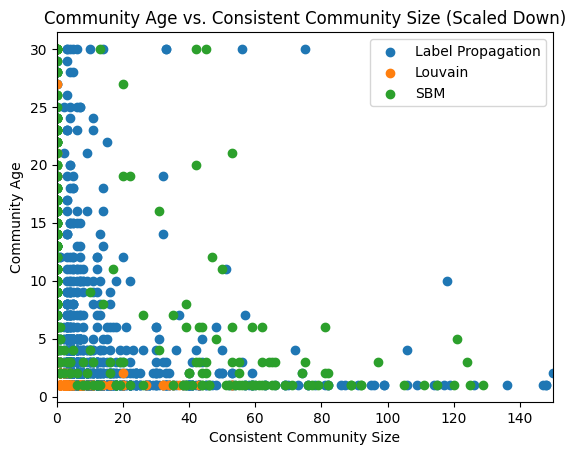

In [ ]:
per_algo_comm_common_subset_vs_age = {}
for comm_algo in temporal_community_sets.keys():
    algo_comm_common_subsets = {}
    for comm_sets in temporal_community_sets[comm_algo]:
        for comm_set in comm_sets:
            if comm_set[0] == -1:
                continue
            if comm_set[0] in algo_comm_common_subsets:
                algo_comm_common_subsets[comm_set[0]][1] = algo_comm_common_subsets[comm_set[0]][1].intersection(set(comm_set[1]))
                algo_comm_common_subsets[comm_set[0]][0] += 1
            else:
                algo_comm_common_subsets[comm_set[0]] = [1,set(comm_set[1])]
    per_algo_comm_common_subset_vs_age[comm_algo] = algo_comm_common_subsets

for comm_algo in per_algo_comm_common_subset_vs_age.keys():
    x_pts = []
    y_pts = []
    for data in per_algo_comm_common_subset_vs_age[comm_algo].values():
        x_pts.append(data[0])
        y_pts.append(len(data[1]))
    pyplot.scatter(y_pts, x_pts, label=comm_algo)
pyplot.title("Community Age vs. Consistent Community Size")
pyplot.ylabel("Community Age")
pyplot.xlabel("Consistent Community Size")
pyplot.legend()
pyplot.savefig("comm_age_vs_consistent_size_full.png")
pyplot.show()

for comm_algo in per_algo_comm_common_subset_vs_age.keys():
    x_pts = []
    y_pts = []
    for data in per_algo_comm_common_subset_vs_age[comm_algo].values():
        x_pts.append(data[0])
        y_pts.append(len(data[1]))
    pyplot.scatter(y_pts, x_pts, label=comm_algo)
ax = pyplot.gca()
ax.set_xlim([0, 150])
pyplot.title("Community Age vs. Consistent Community Size (Scaled Down)")
pyplot.ylabel("Community Age")
pyplot.xlabel("Consistent Community Size")
pyplot.legend()
pyplot.savefig("comm_age_vs_consistent_size_zoom.png")
pyplot.show()

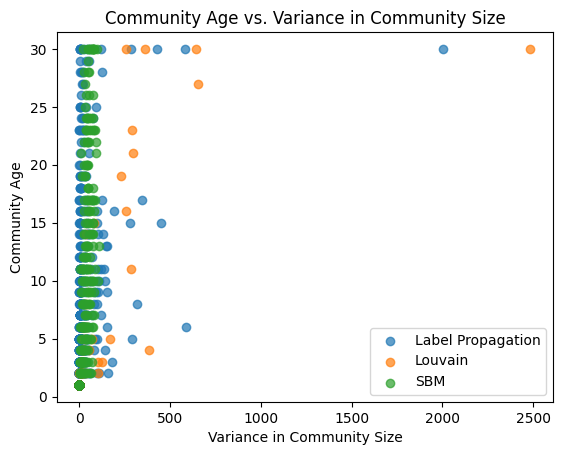

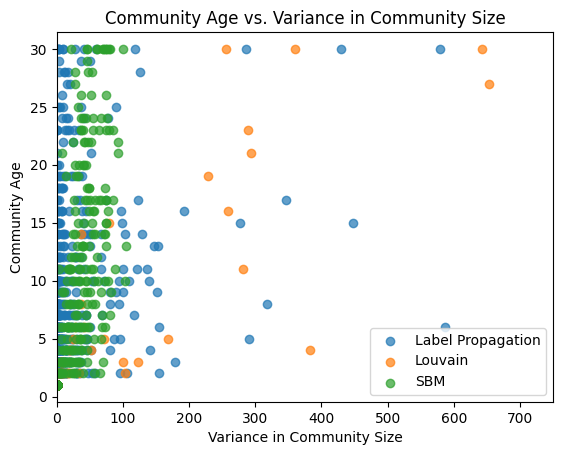

In [ ]:
import numpy as np

per_algo_age_vs_variance = {}
for comm_algo in per_algo_comm_size.keys():
    per_algo_age_vs_variance[comm_algo] = [[],[]]
    for comm_label in per_algo_comm_size[comm_algo].keys():
        per_algo_age_vs_variance[comm_algo][0].append(len(per_algo_comm_size[comm_algo][comm_label][0]))
        per_algo_age_vs_variance[comm_algo][1].append(np.std(per_algo_comm_size[comm_algo][comm_label][1]))

for comm_algo in per_algo_age_vs_variance.keys():
    pyplot.scatter(per_algo_age_vs_variance[comm_algo][1], per_algo_age_vs_variance[comm_algo][0], label=comm_algo, alpha=0.7)
pyplot.title("Community Age vs. Variance in Community Size")
pyplot.ylabel("Community Age")
pyplot.xlabel("Variance in Community Size")
pyplot.legend()
pyplot.savefig("comm_age_vs_size_variance_full.png")
pyplot.show()

for comm_algo in per_algo_age_vs_variance.keys():
    pyplot.scatter(per_algo_age_vs_variance[comm_algo][1], per_algo_age_vs_variance[comm_algo][0], label=comm_algo, alpha=0.7)
pyplot.title("Community Age vs. Variance in Community Size")
pyplot.ylabel("Community Age")
pyplot.xlabel("Variance in Community Size")
pyplot.legend()
ax = pyplot.gca()
ax.set_xlim([0, 750])
pyplot.legend()
pyplot.savefig("comm_age_vs_size_variance_zoom.png")

Label Propagation
Label (59) Consistent Size (75)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9306289,0.151452,1993-06-18T16:50:00Z,"F. E. Close, R. G. Roberts,",Consistent Analysis of the Spin Content of the...,The recent measurements of lepton nucleon sc...
1,9305306,0.097187,1993-05-24T14:18:31Z,"John Ellis, Marek Karliner,",Analysis of Data on Polarized Lepton-Nucleon S...,We re-analyze data on deep inelastic polariz...
2,9404270,0.093891,1994-04-15T08:56:12Z,"the SMC,",Measurement of the Spin-Dependent Structure Fu...,We have measured the spin-dependent structur...
3,9311255,0.062196,1993-11-10T08:41:00Z,"G. Altarelli, P. Nason, G. Ridolfi,",On the Q^2 Dependence of Measured Polarized St...,We analyse the available data on the polariz...
4,9403383,0.019069,1994-03-29T08:09:31Z,"S. A. Larin,",The next-to-leading QCD approximation to the E...,The \alpha_s^2 correction to the Ellis-Jaffe...
5,9310272,0.018847,1993-10-12T16:06:00Z,"John Ellis, Marek Karliner,",Spin Structure Functions,We review the theory and phenomenology of de...
6,9309336,0.018760,1993-09-30T08:04:44Z,"T. Morii, S. Tanaka, T. Yamanishi,",Effects of the large gluon polarization on $xg...,The recent SMC data of $xg_1^d(x)$ are repro...
7,9407287,0.017353,1994-07-13T13:39:00Z,"John Ellis, Marek Karliner,",Determination of $α_s$ and the Nucleon Spin De...,New data on polarized $\mu-p$ and $e-p$ scat...
8,9212257,0.016421,1992-12-14T14:50:35Z,"Véronique Bernard, Norbert Kaiser, Ulf-G. Meiß...",Small Momentum Evolution of the Extended Drell...,We investigate the momentum dependence of th...
9,9310306,0.015739,1993-10-18T15:19:20Z,"S. D. Bass, A. W. Thomas,",The Spin Structure of the Nucleon,We provide an introduction to the ideas of s...


Label (12) Consistent Size (56)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9203203,0.170542,1992-03-03T16:32:33Z,"M. Dine, R. Leigh, P. Huet, A. Linde, D. Linde,",Towards the Theory of Cosmological Phase Trans...,We discuss recent progress (and controversie...
1,9203201,0.089433,1992-02-24T20:07:00Z,"M. Dine, R. G. Leigh, P. Huet, A. D. Linde, D....",Comments on the Electroweak Phase Transition,We report on an investigation of various pro...
2,9206227,0.046500,1992-06-17T13:44:51Z,"J. R. Espinosa, M. Quirós, F. Zwirner,",On the phase transition in the scalar theory,The basic tool for the study of the electrow...
3,9206266,0.046360,1992-06-30T23:58:47Z,"Stanley Myint,",Baryogenesis Constraints on the Minimal Supers...,Requirement that the vacuum expectation valu...
4,9208215,0.029820,1992-08-08T01:21:00Z,"John March-Russell,",On the Possibility of Second-Order Phase Trans...,"In the ``Type-II'' regime, $m_{\rm Higgs}\ga..."
5,9212288,0.024956,1992-12-21T00:38:00Z,"John Bagnasco, Michael Dine,",Some Two-Loop Corrections to the Finite Temper...,Perturbation theory at finite temperature su...
6,9212224,0.022735,1992-12-05T00:57:10Z,"P. Huet, K. Kajantie, R. G. Leigh, B. -H. Liu,...",Hydrodynamic Stability Analysis of Burning Bub...,Assuming that the electroweak and QCD phase ...
7,9303317,0.021129,1993-03-30T19:41:55Z,"J. R. Espinosa, M. Quiros, F. Zwirner,",On the electroweak phase transition in the Min...,We study the finite-temperature effective po...
8,9306238,0.018033,1993-06-07T15:09:00Z,"D. Boyanovsky, C. A. de Carvalho,",Real Time Analysis of Thermal Activation via S...,We study the process of thermal activation m...
9,9308364,0.016307,1993-08-31T03:58:16Z,"Mark Alford, John March-Russell,",Radiatively-Induced First-Order Phase Transiti...,We advocate a (Wilson) renormalization-group...


Label (42) Consistent Size (33)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9302280,0.111505,1993-02-19T19:08:00Z,"Z. Bern, L. Dixon, D. A. Kosower,",One-Loop Corrections to Five-Gluon Amplitudes,We present the one-loop helicity amplitudes ...
1,9205205,0.101598,1992-05-05T18:25:00Z,"Matthew J. Strassler,",Field Theory Without Feynman Diagrams: One-Loo...,In this paper the connection between standar...
2,9207266,0.050820,1992-07-28T12:29:00Z,"C. S. Lam,",Navigating Around the Algebraic Jungle of QCD:...,A method is developed whereby spinor helicit...
3,9212308,0.045899,1992-12-24T22:32:49Z,"Z. Bern, L. Dixon, D. A. Kosower,",Dimensionally Regulated One-Loop Integrals,We describe methods for evaluating one-loop ...
4,9210213,0.040337,1992-10-05T18:14:29Z,"G. Mahlon, T. M. Yan,",Multiphoton Production at High Energies in the...,We examine multiphoton production in the ele...
5,9312276,0.036548,1993-12-14T15:11:49Z,"Gregory Mahlon,",Multigluon Helicity Amplitudes Involving a Qua...,We apply the solution to the recursion relat...
6,9305239,0.035845,1993-05-11T13:25:16Z,"Zoltan Kunszt, Adrian Signer, Zoltán Trócsányi,",One-loop helicity amplitudes for all 2 -> 2 pr...,One loop corrections to the helicity amplitu...
7,9311213,0.033791,1993-11-02T22:28:39Z,"Gregory Mahlon,",One Loop Multiphoton Helicity Amplitudes,We use the solutions to the recursion relati...
8,9210214,0.033557,1992-10-05T18:14:58Z,"G. Mahlon,",Multiphoton Production at High Energies in the...,We examine multiphoton production in the ele...
9,9210212,0.033557,1992-10-05T18:13:55Z,"G. Mahlon, T. M. Yan, C. Dunn,",Generalized Gluon Currents and Applications in...,We consider the process containing two quark...


Label (54) Consistent Size (33)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9209203,0.127396,1992-09-01T20:12:14Z,"Lowell S. Brown,",Summing tree graphs at threshold,The solution of the classical field equation...
1,9209240,0.085831,1992-09-15T19:45:07Z,"M. B. Voloshin,",Summing One-Loop Graphs at Multi-Particle Thre...,It is shown that the technique recently sugg...
2,9212280,0.052425,1992-12-18T09:46:27Z,"E. N. Argyres, C. G. Papadopoulos, R. Kleiss,",On amplitude zeros at threshold,The occurrence of zeros of 2 to n amplitudes...
3,9210244,0.041117,1992-10-19T15:54:38Z,"M. B. Voloshin,",Zeros of Tree-Level Amplitudes at Multi-Boson ...,Propagation of particles with emission of ar...
4,9303321,0.035692,1993-03-31T19:48:36Z,"E. N. Argyres, Ronald H. P. Kleiss, Costas G. ...",Multiscalar amplitudes to all orders in pertur...,A method for calculating loop amplitudes at ...
5,9305219,0.031926,1993-05-06T21:44:40Z,"A. S. Gorsky, M. B. Voloshin,",Non-Perturbative Production of Multi-Boson Sta...,The amplitude of production of $n$ on-mass-s...
6,9209287,0.031504,1992-09-28T21:37:52Z,"B. H. Smith,",Summing one-loop graphs in a theory with broke...,The method suggested by Lowell Brown for cal...
7,9303322,0.030942,1993-03-31T19:52:30Z,"E. N. Argyres, R. Kleiss, C. G. Papadopoulos,",Nullification of multi-Higgs threshold amplitu...,We show that nullification of all tree-order...
8,9301255,0.027565,1993-01-21T15:42:40Z,"Brian Hendee Smith,",Calculation of processes involving many partic...,A diagrammatic technique is derived for calc...
9,9307213,0.026609,1993-07-02T14:42:26Z,"M. V. Libanov, V. A. Rubakov, S. V. Troitsky,",Tree amplitudes at multiparticle threshold in ...,Tree amplitudes of the production of two kin...


Label (23) Consistent Size (14)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9307226,0.165258,1993-07-06T17:53:36Z,"G. F. Giudice, E. Roulet,",Conditions on supersymmetry soft-breaking term...,We study the effect of integrating out the h...
1,9403306,0.123841,1994-03-17T21:01:05Z,"Paul Langacker, Nir Polonsky,",Implications of Yukawa unification for the Hig...,The SU(5) unification-scale relation h_b=h_t...
2,9402254,0.090595,1994-02-09T05:18:00Z,"Yoshiharu Kawamura, Hitoshi Murayama, Masahiro...",Probing Symmetry-Breaking Pattern Using Sfermi...,We study the mass spectrum of superparticles...
3,9405252,0.069131,1994-05-09T12:52:55Z,"Ralf Hempfling,",On the fine-tuning problem in minimal SO(10) S...,In grand unified theories (GUT) based on SO(...
4,9411276,0.067465,1994-11-11T23:24:23Z,"H. -C. Cheng, L. J. Hall,",Squark and Slepton Mass Relations in Grand Uni...,In the minimal supersymmetric standard model...
5,9410231,0.063870,1994-10-06T11:37:45Z,"Nir Polonsky, Alex Pomarol,",Non-Universal GUT Corrections to the Soft Term...,Potentially large non-universal corrections ...
6,9407404,0.063870,1994-07-29T17:18:53Z,"M. Olechowski, S. Pokorski,",Electroweak Symmetry Breaking with Non-Univers...,We discuss radiative electroweak symmetry br...
7,9407251,0.063870,1994-07-07T15:29:40Z,"D. Matalliotakis, H. P. Nilles,",Implications of non-universality of soft terms...,Most discussions of supersymmetric grand uni...
8,9304218,0.059993,1993-04-05T18:35:24Z,"John S. Hagelin, S. Kelley, Toshiaki Tanaka,",Exact Supersymmetric Amplitude for \kkb\/ and ...,We present the most general supersymmetric a...
9,9503445,0.046421,1995-03-27T18:14:47Z,"Chris Kolda, Stephen P. Martin,",Low-energy supersymmetry with D-term contribut...,We investigate how the predictions of the Mi...


Louvain
Label (0) Consistent Size (1387)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9212203,0.011086,1992-12-01T22:24:05Z,"M. Ciuchini, E. Franco, G. Martinelli, L. Reina,",$ε^{\prime}/ε$ at the next-to-leading order in...,We present a new calculation of the CP viola...
1,9303284,0.004374,1993-03-19T08:53:27Z,"Andrzej J. Buras, Matthias Jamin, Markus E. La...",The Anatomy of $\varepsilon'/\varepsilon$ Beyo...,We use the recently calculated two--loop ano...
2,9403339,0.003586,1994-03-22T15:50:45Z,"Chang-Hwan Lee, G. E. Brown, Mannque Rho,","Kaon Condensation in ``Nuclear Star"" Matter",The critical density for kaon condensation i...
3,9304257,0.003065,1993-04-15T16:31:44Z,"M. Ciuchini, E. Franco, G. Martinelli, L. Reina,",The $ΔS=1$ Effective Hamiltonian Including Nex...,In this paper we present a calculation of th...
4,9406263,0.003002,1994-06-09T13:48:11Z,"C. R. Allton, M. Ciuchini, M. Crisafulli, E. F...",Quark Masses from Lattice QCD at the Next-to-L...,Using the results of several quenched lattic...
5,9209288,0.002812,1992-09-28T22:43:01Z,"H. Lew, R. R. Volkas,",Discrete quark-lepton symmetry need not pose a...,Quarks and leptons may be related to each ot...
6,9308223,0.002779,1993-08-04T15:31:11Z,"Michael A. Earnshaw, Margaret James,",Stability of Two Doublet Electroweak Strings,Vortex solutions in the two Higgs doublet el...
7,9210245,0.002726,1992-10-19T17:49:00Z,"O. W. Greenberg,",Scaling limit of a non-relativistic model,I calculate the structure function for scatt...
8,9306208,0.002627,1993-06-02T10:06:11Z,"F. R. Klinkhamer,",Existence of a New Instanton in Constrained Ya...,Our goal is to discover possible new 4-dimen...
9,9212297,0.002589,1992-12-21T22:14:34Z,"L. Durand, K. Honjo, R. Gandhi, I. Sarcevic, H...",Jets and Jet Multiplicities in High Energy Pho...,We discuss the theory of jet events in high-...


SBM
Label (5) Consistent Size (45)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9207214,0.183926,1992-07-04T01:06:35Z,"I. I. Bigi, N. G. Uraltsev, A. I. Vainshtein,",Nonperturbative Corrections to Inclusive Beaut...,We present a selfconsistent method for treat...
1,9304225,0.144372,1993-04-06T22:28:11Z,"I. I. Bigi, M. Shifman, N. G. Uraltsev, A. Vai...",QCD Predictions for Lepton Spectra in Inclusiv...,We derive the lepton spectrum in semileptoni...
2,9307247,0.112354,1993-07-12T04:08:02Z,"B. Blok, L. Koyrakh, M. Shifman, A. I. Vainsht...",Differential Distributions in Semileptonic Dec...,"Several references added, typos corrected.\n"
3,9308246,0.076536,1993-08-08T19:07:16Z,"Aneesh V. Manohar, Mark B. Wise,",Inclusive Semileptonic B and Polarized Lambda_...,The differential decay spectrum $d\Gamma/dE_...
4,9308262,0.036009,1993-08-11T16:01:52Z,"Thomas Mannel,",Operator Product Expansion for Inclusive Semil...,Inclusive semileptonic decays are discussed ...
5,9307291,0.020685,1993-07-18T14:52:37Z,"P. Ball, V. M. Braun,",Next--to--Leading Order Corrections to Meson M...,We use the QCD sum rule approach to calculat...
6,9312359,0.020424,1993-12-31T05:45:29Z,"I. I. Bigi, M. A. Shifman, N. G. Uraltsev, A. ...",On the Motion of Heavy Quarks inside Hadrons: ...,In previous papers we have pointed out that ...
7,9311325,0.018038,1993-11-21T18:55:37Z,"Matthias Neubert,",QCD-Based Interpretation of the Lepton Spectru...,We present a QCD-based approach to the endpo...
8,9401255,0.015893,1994-01-14T15:04:41Z,"C. H. Jin, W. F. Palmer, E. A. Paschos,",A Parton Model for Inclusive Semileptonic B Me...,The parton model for semileptonic B meson de...
9,9312306,0.015780,1993-12-20T03:33:07Z,"Adam F. Falk, Elizabeth Jenkins, Aneesh V. Man...",QCD Corrections and the Endpoint of the Lepton...,"Recently, Neubert has suggested that a certa..."


Label (34) Consistent Size (42)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9306289,0.172240,1993-06-18T16:50:00Z,"F. E. Close, R. G. Roberts,",Consistent Analysis of the Spin Content of the...,The recent measurements of lepton nucleon sc...
1,9404270,0.104358,1994-04-15T08:56:12Z,"the SMC,",Measurement of the Spin-Dependent Structure Fu...,We have measured the spin-dependent structur...
2,9305306,0.102903,1993-05-24T14:18:31Z,"John Ellis, Marek Karliner,",Analysis of Data on Polarized Lepton-Nucleon S...,We re-analyze data on deep inelastic polariz...
3,9311255,0.071150,1993-11-10T08:41:00Z,"G. Altarelli, P. Nason, G. Ridolfi,",On the Q^2 Dependence of Measured Polarized St...,We analyse the available data on the polariz...
4,9310272,0.027151,1993-10-12T16:06:00Z,"John Ellis, Marek Karliner,",Spin Structure Functions,We review the theory and phenomenology of de...
5,9305322,0.023498,1993-05-26T14:59:10Z,"S. D. Bass, A. W. Thomas,",Mapping the x dependence of the axial anomaly ...,We discuss the role of the U(1) axial anomal...
6,9311285,0.023242,1993-11-12T15:59:03Z,"B. Ehrnsperger, L. Mankiewicz, A. Schäfer,",OPE analysis for polarized deep inelastic scat...,We present an explicit OPE analysis for the ...
7,9310306,0.022746,1993-10-18T15:19:20Z,"S. D. Bass, A. W. Thomas,",The Spin Structure of the Nucleon,We provide an introduction to the ideas of s...
8,9403383,0.022037,1994-03-29T08:09:31Z,"S. A. Larin,",The next-to-leading QCD approximation to the E...,The \alpha_s^2 correction to the Ellis-Jaffe...
9,9305323,0.021084,1993-05-26T15:07:42Z,"S. D. Bass,",Gauge symmetry and the EMC spin effect,We emphasise the EMC spin effect as a proble...


Label (32) Consistent Size (13)


,arXiv ID,PageRank,Date Published,Author(s),Title,Summary
0,9207245,0.146594,1992-07-17T09:48:42Z,"Fred Adams, J. R. Bond, Katherine Freese, Josh...","Natural Inflation: Particle Physics Models, Po...","A pseudo-Nambu-Goldstone boson, with a poten..."
1,9407248,0.133790,1994-07-07T06:55:18Z,"Lisa Randall, Scott Thomas,",Solving the Cosmological Moduli Problem with W...,Many models of supersymmetry breaking involv...
2,9406319,0.111168,1994-06-15T17:39:45Z,"G. Dvali, Q. Shafi, R. Schaefer,",Large Scale Structure and Supersymmetric Infla...,We explore constraints on the spectral index...
3,9311326,0.098442,1993-11-21T21:24:09Z,"Hitoshi Murayama, Hiroshi Suzuki, T. Yanagida,...",Chaotic Inflation and Baryogenesis in Supergra...,"We propose a K\""ahler potential in supergrav..."
4,9405389,0.089877,1994-05-26T15:00:58Z,"Ewan D. Stewart,","Inflation, Supergravity and Superstrings",The positive potential energy required for i...
5,9503259,0.085830,1995-03-07T19:14:23Z,"Gia Dvali,",INFLATION VERSUS THE COSMOLOGICAL MODULI PROBLEM,We show that in generic supergravity theorie...
6,9503303,0.065430,1995-03-12T04:57:44Z,"Michael Dine, Lisa Randall, Scott Thomas,",Supersymmetry Breaking in the Early Universe,Supersymmetry breaking in the early universe...
7,9503375,0.050985,1995-03-18T16:49:41Z,"Gia Dvali,",INFLATION INDUCED SUSY BREAKING AND FLAT VACUU...,We discuss how the inflation induced supersy...
8,9504420,0.043577,1995-04-28T03:30:42Z,"Tony Gherghetta, Gordon L. Kane,",Chaotic inflation and a radiatively generated ...,We consider a phenomenological extension of ...
9,9502417,0.043577,1995-02-28T21:13:26Z,"David H. Lyth, Ewan D. Stewart,",Cosmology with a TeV mass GUT Higgs,The most natural way to break the GUT gauge ...


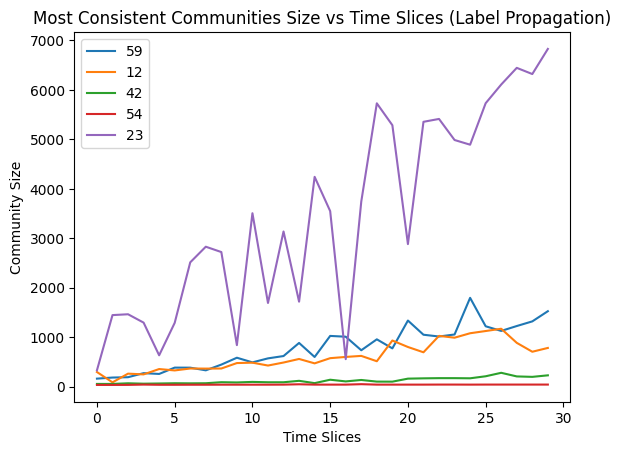

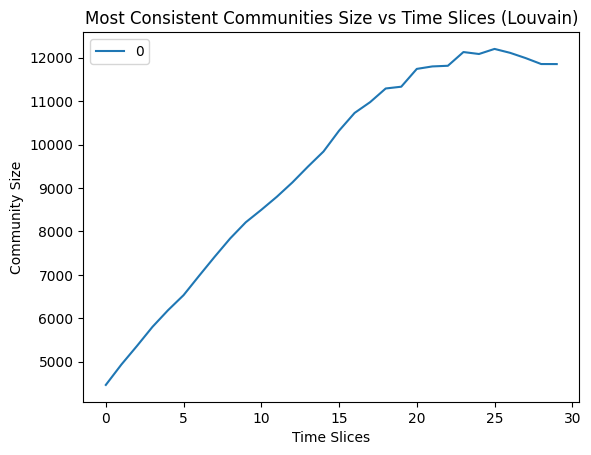

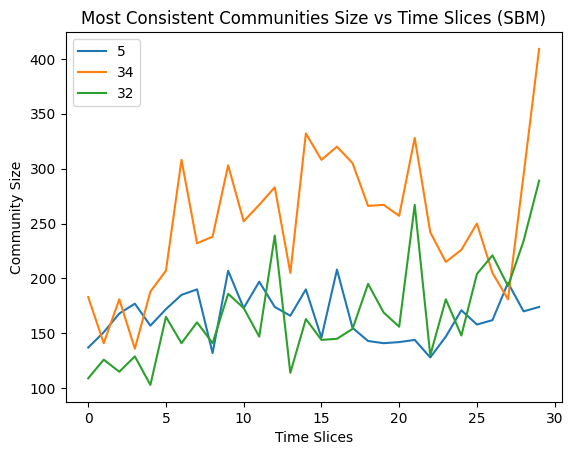

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time

from google.colab import data_table
data_table.enable_dataframe_formatter()

test_communities = {}
for comm_algo in per_algo_comm_common_subset_vs_age.keys():
    comm_sets = [[label, data] for label, data in per_algo_comm_common_subset_vs_age[comm_algo].items()]
    comm_sets.sort(key=lambda x: (x[1][0], len(x[1][1])), reverse=True)
    comm_sets = comm_sets[:5]
    print(comm_algo)
    test_communities[comm_algo] = []
    for comm_set in comm_sets:
        if len(comm_set[1][1]) == 0:
            continue
        test_communities[comm_algo].append(comm_set[0])
        print(f"Label ({comm_set[0]})", f"Consistent Size ({len(comm_set[1][1])})") #, "10 Papers:", [g.vp.arxiv_id[v] for v in comm_set[1][1]][:10])

        # Now apply page rank to these communities
        # https://arxiv.org/ftp/arxiv/papers/1012/1012.4872.pdf
        # First create a vprop that is True for all nodes in this communtiy
        temp_is_comm_member = g.new_vp("bool")
        temp_is_comm_member.set_value(False)
        for node_idx in comm_set[1][1]:
            temp_is_comm_member[node_idx] = True

        # Now get a graphView with only these nodes
        temp_comm_graph = GraphView(g, vfilt=temp_is_comm_member)

        # Now calculate PageRank
        paper_pageranks = pagerank(temp_comm_graph)

        # Get only page ranks for nodes in this commmunity
        comm_pageranks = []
        for node_idx in comm_set[1][1]:
            comm_pageranks.append((paper_pageranks[node_idx], g.vp.arxiv_id[node_idx]))
        comm_pageranks.sort(reverse=True)

        # Keep only first 10 papers
        comm_pageranks = comm_pageranks[:min(len(comm_pageranks), 10)]

        # Now for each of these papers, use the arXiv API to get titles,
        # descriptions, and authors.
        top_comm_papers = {"arXiv ID" : [], "PageRank" : [], "Date Published" : [], "Author(s)" : [], "Title" : [], "Summary" : []}

        # https://stackoverflow.com/questions/1912434/how-to-parse-xml-and-get-instances-of-a-particular-node-attribute
        for paper_pagerank,paper_id in comm_pageranks:
            top_comm_papers["arXiv ID"].append(paper_id)
            top_comm_papers["PageRank"].append(paper_pagerank)

            # https://info.arxiv.org/help/api/user-manual.html
            # https://info.arxiv.org/help/api/basics.html
            # https://info.arxiv.org/help/api/tou.html
            parsed_xml = BeautifulSoup(requests.get(f"http://export.arxiv.org/api/query?id_list=hep-ph/{paper_id}").content, features="xml")

            # Follow TOU rate-limit by sleeping for 3 seconds
            # NOTE - If you want the paper data from below, use the html file
            #        as this takes some time.
            # time.sleep(3)

            top_comm_papers["Date Published"].append(parsed_xml.feed.entry.published.string)
            temp_author_str = ""
            for i in parsed_xml.feed.entry.findAll("name"):
                temp_author_str += i.string + ", "
            top_comm_papers["Author(s)"].append(temp_author_str)
            top_comm_papers["Title"].append(parsed_xml.feed.entry.title.string)
            top_comm_papers["Summary"].append(parsed_xml.feed.entry.summary.string)

        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
        df_top_comm_papers = pd.DataFrame(data=top_comm_papers)

        display(df_top_comm_papers)

for comm_algo in per_algo_comm_size.keys():
    for comm_label in test_communities[comm_algo]:
        pyplot.plot(per_algo_comm_size[comm_algo][comm_label][0], per_algo_comm_size[comm_algo][comm_label][1], label = str(comm_label))
    pyplot.xlabel("Time Slices")
    pyplot.ylabel("Community Size")
    pyplot.title(f"Most Consistent Communities Size vs Time Slices ({comm_algo})")
    pyplot.legend()
    pyplot.savefig(f"consistent_communities_size_{comm_algo}.png")
    pyplot.show()

In [2]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

date_cutoffs = []

curr_date = datetime.strptime("1995-06-01", "%Y-%m-%d").date()
while curr_date.strftime("%Y-%m-%d") < "2000-06-01":
    date_cutoffs.append(curr_date.strftime("%Y-%m-%d"))
    curr_date += relativedelta(months=+2)

In [ ]:
for comm_label in temporal_community_sets.keys():
    for slice_idx in range(len(temporal_community_sets[comm_label])):
        # https://stackoverflow.com/questions/30839929/graph-tool-graphview-object
        # for slice_idx, date_cutoff in enumerate(date_cutoffs):
        u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoffs[slice_idx]).copy()
        test_boi = u.new_vp("int")
        u.vp.test_labels = test_boi
        my_test_set = temporal_community_sets[comm_label][slice_idx]
        for comm in my_test_set:
            if comm[0] == -1:
                continue
            for vert_idx in comm[1]:
                u.vp.test_labels[vert_idx] = comm[0]

        u = extract_largest_component(u, directed=False)
        u.purge_vertices()
        u.purge_edges()
        u = Graph(u)
        u, new_comm_vals, vcount, ecount, va, ea = condensation_graph(u, u.vp.test_labels, self_loops=True)

        # https://stackoverflow.com/questions/68875330/how-to-create-a-color-dict-for-multiple-items-from-a-data-frame
        # https://seaborn.pydata.org/tutorial/color_palettes.html
        # https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette
        color_map = sns.color_palette("husl", len(temporal_community_sets[comm_label][slice_idx]))

        # https://stackoverflow.com/questions/33596264/graph-tool-how-to-change-vertex-colors
        plot_color = u.new_vertex_property('vector<double>')
        u.vertex_properties['plot_color'] = plot_color
        large_var_cant_name = 0
        for v in u.iter_vertices():
            plot_color[v] = color_map[int(v)]
            if vcount[v] >  vcount[large_var_cant_name]:
                large_var_cant_name = v

        my_test_baab = prop_to_size(ecount, mi=0.1, ma=1)
        my_test_colcocl = u.new_ep("vector<float>")
        for s,t,e in u.iter_edges([g.edge_index]):
            my_test_colcocl[(s,t)] = [1,1,1,my_test_baab[(s,t)]]

        if comm_label == "Label Propagation":
            output_file_name = f"comm_plots/label_slice_{slice_idx}.png"
        elif comm_label == "Louvain":
            output_file_name = f"comm_plots/louvain_slice_{slice_idx}.png"
        else:
            output_file_name = f"comm_plots/sbm_slice_{slice_idx}.png"
        graph_draw(u,
                pos = radial_tree_layout(u, large_var_cant_name),
                vertex_fill_color=plot_color,
                vertex_size=prop_to_size(vcount, mi=30, ma=70),
                edge_pen_width=prop_to_size(ecount, mi=2, ma=8),
                vertex_color=plot_color,
                edge_color = my_test_colcocl,
                output_size = (1000,1000),
                output = output_file_name)

In [ ]:
!zip -r /content/comm_plots.zip /content/comm_plots/
from google.colab import files
files.download("/content/comm_plots.zip")

  adding: content/comm_plots/ (stored 0%)
  adding: content/comm_plots/sbm_slice_22.png (deflated 0%)
  adding: content/comm_plots/label_slice_5.png (deflated 1%)
  adding: content/comm_plots/sbm_slice_27.png (deflated 0%)
  adding: content/comm_plots/label_slice_16.png (deflated 1%)
  adding: content/comm_plots/label_slice_0.png (deflated 1%)
  adding: content/comm_plots/label_slice_9.png (deflated 1%)
  adding: content/comm_plots/louvain_slice_18.png (deflated 1%)
  adding: content/comm_plots/louvain_slice_1.png (deflated 2%)
  adding: content/comm_plots/louvain_slice_21.png (deflated 1%)
  adding: content/comm_plots/louvain_slice_10.png (deflated 1%)
  adding: content/comm_plots/label_slice_25.png (deflated 1%)
  adding: content/comm_plots/sbm_slice_19.png (deflated 1%)
  adding: content/comm_plots/label_slice_28.png (deflated 1%)
  adding: content/comm_plots/louvain_slice_7.png (deflated 1%)
  adding: content/comm_plots/sbm_slice_7.png (deflated 0%)
  adding: content/comm_plots/lou

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
per_algo_comm_conductance = {}

for comm_label in temporal_community_sets.keys():
    per_algo_comm_conductance[comm_label] = []
    print(comm_label)
    for slice_idx in range(len(temporal_community_sets[comm_label])):
        print("Slice Is", slice_idx)
        # https://stackoverflow.com/questions/30839929/graph-tool-graphview-object
        # for slice_idx, date_cutoff in enumerate(date_cutoffs):
        u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoffs[slice_idx]).copy()
        test_boi = u.new_vp("int")
        u.vp.test_labels = test_boi
        my_test_set = temporal_community_sets[comm_label][slice_idx]
        for comm in my_test_set:
            if comm[0] == -1:
                continue
            for vert_idx in comm[1]:
                u.vp.test_labels[vert_idx] = comm[0]

        u = extract_largest_component(u, directed=False)
        u.purge_vertices()
        u.purge_edges()
        u = Graph(u)
        u, node_comm_labels, vcount, ecount, va, ea = condensation_graph(u, u.vp.test_labels, self_loops=True)

        num_total_ecount = 0
        for s,t,e in u.iter_edges([ecount]):
            num_total_ecount += e
            if s is t:
                num_total_ecount += e

        this_slice_conductance = []
        for v in u.iter_vertices():
            a_v = 0
            v_conductance = 0
            for s,t,w in u.iter_all_edges(v, [ecount]):
                if s is t:
                    a_v += w
                else:
                    a_v += w
                    v_conductance += w
            v_conductance /= min(a_v, num_total_ecount-a_v+v_conductance)
            this_slice_conductance.append((node_comm_labels[v], v_conductance))

        per_algo_comm_conductance[comm_label].append(this_slice_conductance)

Label Propagation
Slice Is 0
Slice Is 1
Slice Is 2
Slice Is 3
Slice Is 4
Slice Is 5
Slice Is 6
Slice Is 7
Slice Is 8
Slice Is 9
Slice Is 10
Slice Is 11
Slice Is 12
Slice Is 13
Slice Is 14
Slice Is 15
Slice Is 16
Slice Is 17
Slice Is 18
Slice Is 19
Slice Is 20
Slice Is 21
Slice Is 22
Slice Is 23
Slice Is 24
Slice Is 25
Slice Is 26
Slice Is 27
Slice Is 28
Slice Is 29
Louvain
Slice Is 0
Slice Is 1
Slice Is 2
Slice Is 3
Slice Is 4
Slice Is 5
Slice Is 6
Slice Is 7
Slice Is 8
Slice Is 9
Slice Is 10
Slice Is 11
Slice Is 12
Slice Is 13
Slice Is 14
Slice Is 15
Slice Is 16
Slice Is 17
Slice Is 18
Slice Is 19
Slice Is 20
Slice Is 21
Slice Is 22
Slice Is 23
Slice Is 24
Slice Is 25
Slice Is 26
Slice Is 27
Slice Is 28
Slice Is 29
SBM
Slice Is 0
Slice Is 1
Slice Is 2
Slice Is 3
Slice Is 4
Slice Is 5
Slice Is 6
Slice Is 7
Slice Is 8
Slice Is 9
Slice Is 10
Slice Is 11
Slice Is 12
Slice Is 13
Slice Is 14
Slice Is 15
Slice Is 16
Slice Is 17
Slice Is 18
Slice Is 19
Slice Is 20
Slice Is 21
Slice Is 22
Slic

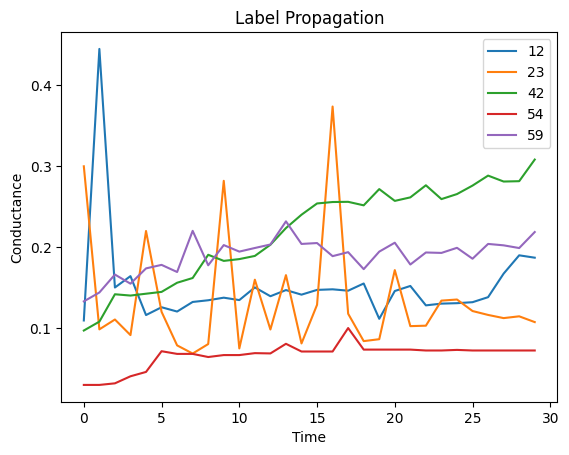

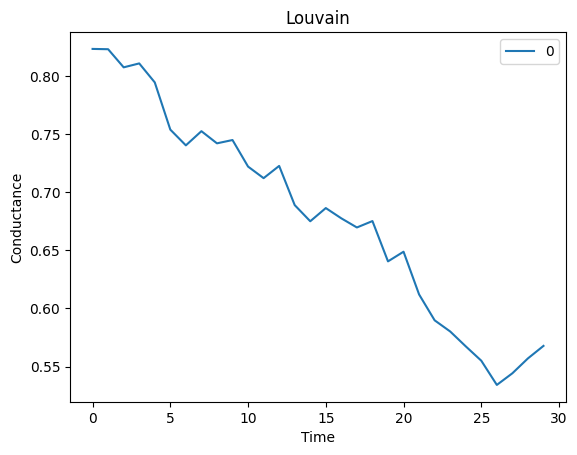

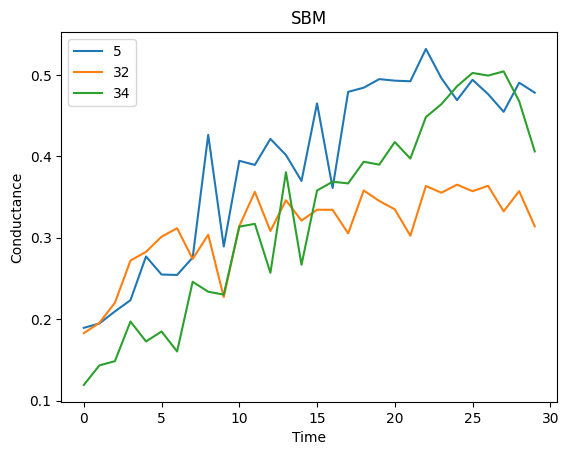

In [13]:
from matplotlib import pyplot

top_comms_dict = {"Label Propagation" : [12, 23, 42, 54, 59], "Louvain" : [0], "SBM" : [5, 32, 34]}

for algo_name in top_comms_dict.keys():
    for comm_label in top_comms_dict[algo_name]:
        conduct_data = []
        time_slices = []
        for slice_idx, comm_set in enumerate(per_algo_comm_conductance[algo_name]):
            for comm in comm_set:
                if comm[0] == comm_label:
                    conduct_data.append(comm[1])
                    time_slices.append(slice_idx)
        pyplot.plot(time_slices, conduct_data, label = str(comm_label))
    pyplot.legend()
    pyplot.title(algo_name)
    pyplot.xlabel("Time")
    pyplot.ylabel("Conductance")
    if algo_name == "Louvain":
        pyplot.savefig("louvain_conductance_vs_time.png")
    elif algo_name == "SBM":
        pyplot.savefig("sbm_conductance_vs_time.png")
    else:
        pyplot.savefig("label_conductance_vs_time.png")
    pyplot.show()